# Analyse Load SECO 

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import plotly.express as px

import statsmodels

import hakom
import getpass

In [3]:
api_pwd = getpass.getpass()

In [4]:
auth_params = hakom.authorization.AuthParams(
    username = 'aeneas',
    password = api_pwd,
)

service_config = hakom.service.ServiceConfig(
    base_url="http://V10FUNDE:52267/3_9_2/api/",
    auth_params=auth_params,
    repository='ZAMS'
)

hakom.initialize(service_config)

## Load Data

In [5]:
metainfo_observed = hakom.repositories.timeseries.metainfo.get('491') # Observed Load Data "Carga Sudeste"



In [6]:
query_params = []
query_params.append(hakom.commons.QueryParam("id", "491"))
query_params.append(hakom.commons.QueryParam("from", metainfo_observed['DataPeriod']['From']))
query_params.append(hakom.commons.QueryParam("to", metainfo_observed['DataPeriod']['To']))

timeseries_data= hakom.repositories.timeseriescollections.data.get(query_params,hakom.errorhandling.BulkResultBehaviours.FullResult)
matrix = hakom.converters.timeseries_data_collection_matrix(timeseries_data)
 
df = pd.DataFrame(matrix)


In [7]:
df.head()

,From,Carga Sudeste/Centro-Oeste
0,2017-12-31T23:00:00Z,30101.6920
1,2018-01-01T00:00:00Z,29904.9400
2,2018-01-01T01:00:00Z,30989.1815
3,2018-01-01T02:00:00Z,30770.7970
4,2018-01-01T03:00:00Z,30124.9915


In [8]:
df['From'] = pd.to_datetime(df['From'], format="%Y-%m-%d %H:%M:%S")
df.set_index('From', inplace=True)


In [108]:
df.tail(100)

,Carga Sudeste/Centro-Oeste
From,
2022-05-13 20:00:00+00:00,45702.3650
2022-05-13 21:00:00+00:00,44820.9400
2022-05-13 22:00:00+00:00,43298.3820
2022-05-13 23:00:00+00:00,41195.0910
2022-05-14 00:00:00+00:00,38739.7625
...,...
2022-05-17 19:00:00+00:00,46338.7900
2022-05-17 20:00:00+00:00,44769.1405
2022-05-17 21:00:00+00:00,43497.9015


## Explore 

In [114]:
year2019 = df


start = ['2018-01-01']
end = ['2018-12-31']
#time = (year2019.index>=start) & (year2019.index<=end)
# WIESO WILLST DU ARSCHKEKS NICHT

#time = year2019[year2019.From >= datetime.datetime(2018, b1, 1)]

In [9]:
df2018 = df.loc['2018-01-01':'2019-01-01']
df2018

,Carga Sudeste/Centro-Oeste
From,
2018-01-01 00:00:00+00:00,29904.9400
2018-01-01 01:00:00+00:00,30989.1815
2018-01-01 02:00:00+00:00,30770.7970
2018-01-01 03:00:00+00:00,30124.9915
2018-01-01 04:00:00+00:00,29436.4990
...,...
2019-01-01 19:00:00+00:00,33478.1330
2019-01-01 20:00:00+00:00,36472.6565
2019-01-01 21:00:00+00:00,39218.9200


In [147]:
type(df2018)
df.rename(columns = {'Carga Sudeste/Centro-Oeste':'Load'}, inplace = True)


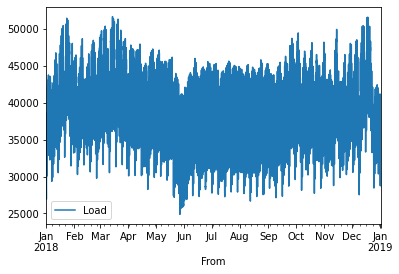

In [119]:
df2018.plot();

### Fill Zero-filled data with mean value

In [149]:
#df = df.replace([df['Carga Sudeste/Centro-Oeste']==0], [np.mean(df['Carga Sudeste/Centro-Oeste'],2)], inplace=True)
#df_replaces_zeros = df.replace(df.Load == 0, (np.round(np.mean(df.Load), 2)))

df_replaced_zeros = df.loc[df['Load'] == 0, "Load"] = (np.round(np.mean(df.Load), 2))

<AxesSubplot:xlabel='From'>

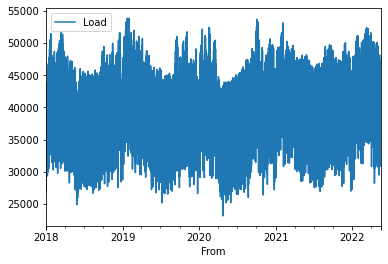

In [150]:
df.plot()

In [139]:
df_replaced_zeros.plot()

AttributeError: 'numpy.float64' object has no attribute 'plot'

### Decompose time series 

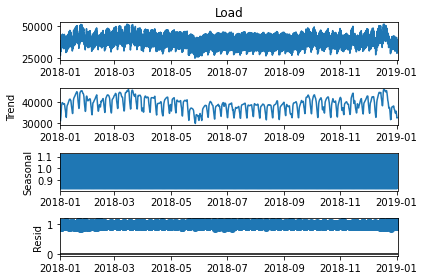

In [153]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2018['Load'], model='mul')  # model='mul' also works
result.plot();

In [2]:
from statsmodels.tsa.seasonal import MSTL

In [11]:
stl_kwargs = {"seasonal_deg": 0} 
model = MSTL(df2018, periods=(24, 24 * 7), stl_kwargs=stl_kwargs)
res = model.fit()

In [12]:
seasonal = res.seasonal # contains both seasonal components
trend = res.trend
residual = res.resid

In [23]:
plt.rc("figure", figsize=(16, 12));

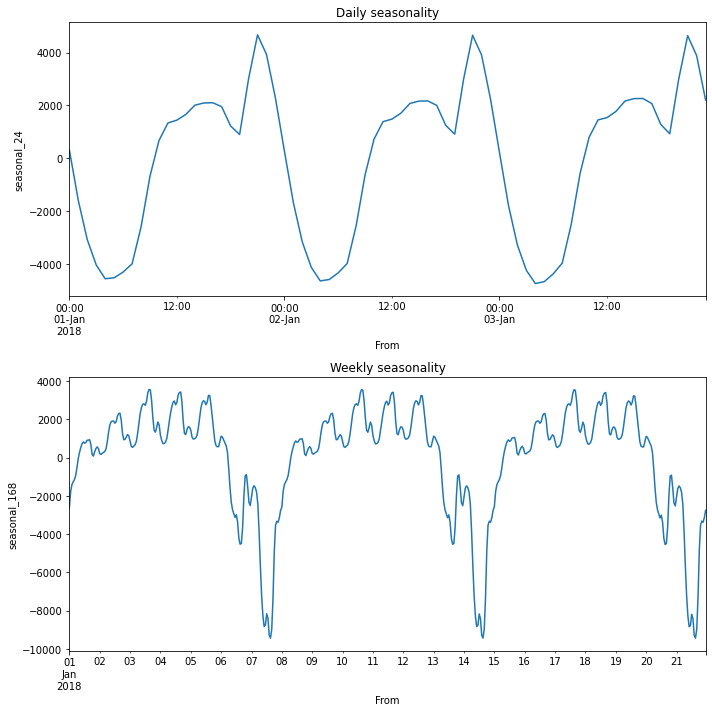

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
res.seasonal["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

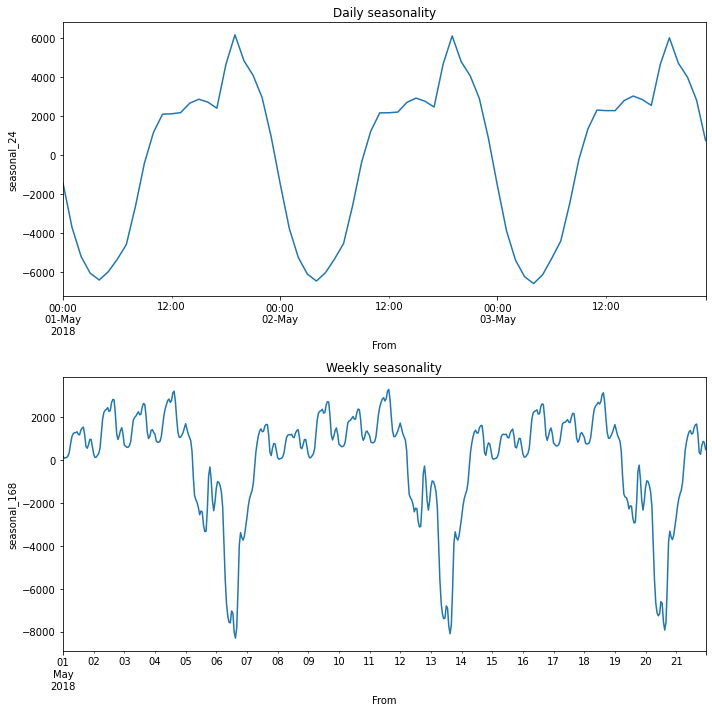

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
mask = res.seasonal.index.month==5
res.seasonal[mask]["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal[mask]["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

## Comparing Resulty & Playing with plotly

Loading Data

In [32]:
import plotly.graph_objects as go

In [6]:
metainfo_observed = hakom.repositories.timeseries.metainfo.get('491') # Observed Load Data "Carga Sudeste"


query_params = []
query_params.append(hakom.commons.QueryParam("id", "3270"))
query_params.append(hakom.commons.QueryParam("id", "1579"))
query_params.append(hakom.commons.QueryParam("id", "1575"))
query_params.append(hakom.commons.QueryParam("from", metainfo_observed['DataPeriod']['From']))
query_params.append(hakom.commons.QueryParam("to", metainfo_observed['DataPeriod']['To']))

timeseries_data= hakom.repositories.timeseriescollections.data.get(query_params,hakom.errorhandling.BulkResultBehaviours.FullResult)
matrix = hakom.converters.timeseries_data_collection_matrix(timeseries_data)
 
df = pd.DataFrame(matrix)


In [7]:
df['From'] = pd.to_datetime(df['From'], format="%Y-%m-%d %H:%M:%S")
df.set_index('From', inplace=True)

In [26]:
df22 = df.loc['2022-01-01':'2022-05-17']
df22.head()

,Carga Sudeste/Centro-Oeste MAPE Aeneas,Carga Sudeste/Centro-Oeste MAPE ONS,Carga Sudeste/Centro-Oeste MAPE Huez
From,,,
2022-01-01 00:00:00+00:00,0.015589,0.039601,0.005055
2022-01-01 01:00:00+00:00,0.000249,0.037011,0.010307
2022-01-01 02:00:00+00:00,0.008829,0.033618,0.019467
2022-01-01 03:00:00+00:00,0.005567,0.032718,0.005433
2022-01-01 04:00:00+00:00,0.032807,0.031463,0.021036


In [22]:
df22.index

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 01:00:00+00:00',
               '2022-01-01 02:00:00+00:00', '2022-01-01 03:00:00+00:00',
               '2022-01-01 04:00:00+00:00', '2022-01-01 05:00:00+00:00',
               '2022-01-01 06:00:00+00:00', '2022-01-01 07:00:00+00:00',
               '2022-01-01 08:00:00+00:00', '2022-01-01 09:00:00+00:00',
               ...
               '2022-05-17 14:00:00+00:00', '2022-05-17 15:00:00+00:00',
               '2022-05-17 16:00:00+00:00', '2022-05-17 17:00:00+00:00',
               '2022-05-17 18:00:00+00:00', '2022-05-17 19:00:00+00:00',
               '2022-05-17 20:00:00+00:00', '2022-05-17 21:00:00+00:00',
               '2022-05-17 22:00:00+00:00', '2022-05-17 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='From', length=3288, freq=None)

### Plotly

In [44]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE Aeneas"], name="Carga Sudeste/Centro-Oeste MAPE Aeneas"))
fig.add_trace(go.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE ONS"], name="Carga Sudeste/Centro-Oeste MAPE ONS"))
fig.add_trace(go.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE Huez"], name="Carga Sudeste/Centro-Oeste MAPE Huez"))
fig.add_trace(go.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE Huez"], name="Carga Sudeste/Centro-Oeste MAPE Huez"))


fig.show()


In [45]:
fig = px.Figure()

fig.add_trace(px.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE Aeneas"], name="Carga Sudeste/Centro-Oeste MAPE Aeneas"))
fig.add_trace(px.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE ONS"], name="Carga Sudeste/Centro-Oeste MAPE ONS"))
fig.add_trace(px.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE Huez"], name="Carga Sudeste/Centro-Oeste MAPE Huez"))
fig.add_trace(px.Scatter(x=df22.index, y=df22["Carga Sudeste/Centro-Oeste MAPE Huez"], name="Carga Sudeste/Centro-Oeste MAPE Huez"))


fig.show()


AttributeError: module 'plotly.express' has no attribute 'Figure'